In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "/Users/hamid/piibamm/PyBaMM/UMBLFeb2022/data/esoh/"
oCV_DIR = "/Users/hamid/piibamm/PyBaMM/UMBLFeb2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [3]:
# parameter_values = get_parameter_values()


parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 3.0,
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [4]:
# parameter_values.search("Li")

In [5]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm.param

In [6]:
cell =13

## Load eSOH Data and OCV Data

In [7]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

In [8]:
dis_set

' for 150 min'

In [9]:
Peyman_drive = pd.read_csv("../data/Peyman_cycling_DriveCycle.csv", comment="#", header=None).to_numpy()
Created_Drive = pd.read_csv("../data/Created_Drive_2_5Ah.csv", comment="#", header=None).to_numpy()


pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")


experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_d+dis_set,
         "Rest for 5 min",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    drive_cycles={"Peyman_drive": Peyman_drive},

    termination="50% capacity",
#     cccv_handling="ode",
)

# experiment = pybamm.Experiment(
#     [
#         ("Run Peyman_drive (A)",
#          "Rest for 5 min",
#          "Charge at 1.5C until 4.2V", 
#          "Hold at 4.2V until C/50")
#     ] *dfe.N.iloc[-1],
#     drive_cycles={"Peyman_drive": Peyman_drive},

#     termination="50% capacity",
# #     cccv_handling="ode",
# )

In [10]:
# parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]":2.2296e-7,# 4.0023e-07,
        "Negative electrode LAM constant proportional term [s-1]": 10.7088e-7, #2.228e-6,#1.27272e-06,
        "Positive electrode LAM constant exponential term": 1.02,# 1.3446,
        "Negative electrode LAM constant exponential term": 1.02,#1.3446,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16 ,# 4.60788219e-16, #, 
        "EC diffusivity [m2.s-1]":8.30909086e-19,# 4.56607447e-19,#,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,#1.87422275e+04,#,
        "Lithium plating kinetic rate constant [m.s-1]":7.423e-10,# 9.818e-10,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]": 30000.0,
        
        
        "Positive electrode dissolution exchange current density": 0,
        "Negative electrode dissolution exchange current density": 0,
        
        "Positive electrode dissolution nickel SEI coefficient": 0,
        "Negative electrode dissolution nickel SEI coefficient": 0,
        
        "Positive electrode dissolution nickel intercalation coefficient": 0,
        "Negative electrode dissolution nickel intercalation coefficient": 0,
        
    },
    check_already_exists=False,
)


In [11]:
# pybamm.set_logging_level("NOTICE")

# sim_long13 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe",
#                             rtol=1e-6, 
#                             atol=1e-6,
#                             dt_max=10,
#                                                       ))
# sol_long13 = sim_long13.solve(initial_soc=1, save_at_cycles=1  )


In [12]:
# experiment.operating_conditions

In [13]:
# pybamm.set_logging_level("NOTICE")
all_sumvars_dict = cycle_adaptive_simulation(spm, parameter_values, experiment, SOC_0,save_at_cycles=1, drive_cycle=Peyman_drive)


CasADi - 2023-08-15 12:02:40 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


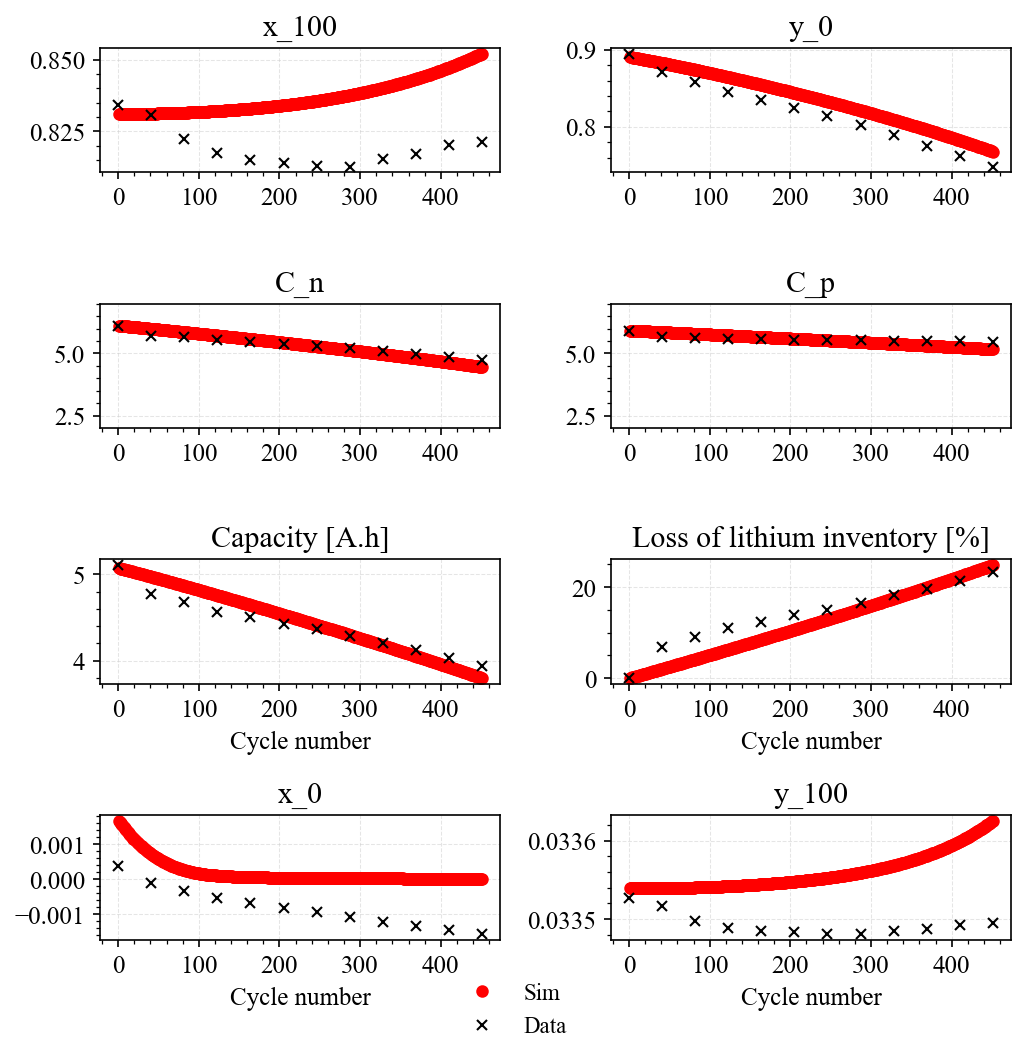

In [14]:
fig = plotc(all_sumvars_dict,dfe);
# fig.savefig(fig_DIR +'fast_sim_'+cell_no+'_new.png')

In [24]:
all_sumvars_dict['C_n']

array([6.11693874, 6.11378456, 6.11062859, 6.10747082, 6.10431126,
       6.1011499 , 6.09798673, 6.09482177, 6.091655  , 6.08848642,
       6.08531604, 6.08214385, 6.07896985, 6.07579404, 6.07261641,
       6.06943696, 6.06625569, 6.0630726 , 6.05988767, 6.05670091,
       6.05351232, 6.05032188, 6.0471296 , 6.04393548, 6.0407395 ,
       6.03754167, 6.03434199, 6.03114044, 6.02793703, 6.02473175,
       6.0215246 , 6.01831557, 6.01510467, 6.01189189, 6.00867722,
       6.00546066, 6.00224221, 5.99902186, 5.99579962, 5.99257548,
       5.98934942, 5.98612146, 5.98289159, 5.9796598 , 5.97642609,
       5.97319046, 5.9699529 , 5.96671342, 5.96347199, 5.96022864,
       5.95698334, 5.9537361 , 5.95048691, 5.94723577, 5.94398267,
       5.94072762, 5.93747061, 5.93421163, 5.93095069, 5.92768777,
       5.92442288, 5.92115601, 5.91788716, 5.91461633, 5.9113435 ,
       5.90806868, 5.90479187, 5.90151306, 5.89823224, 5.89494942,
       5.8916646 , 5.88837775, 5.88508889, 5.88179802, 5.87850

In [13]:
fgdfdfg

NameError: name 'fgdfdfg' is not defined

# Parameter Fitting

## List of Initial Conditions

In [11]:
ic = 1
blam_p = [1e-6,1e-7,1e-8]
blam_n = [1e-5,1e-6,1e-7]
k_sei= [1*2e-16,1/5*2e-16,5*2e-16]
k_pl = 1e-9
 # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]","x_100","y_0"]
    # weights = [1,1/20,5,5]

In [12]:
pybamm.set_logging_level("WARNING")

In [13]:
Peyman_drive

array([[ 1.00000000e+00, -1.14674938e-01],
       [ 2.00000000e+00, -1.15053259e-01],
       [ 3.00000000e+00, -1.15295404e-01],
       ...,
       [ 7.02900000e+03,  6.65317446e-02],
       [ 7.03000000e+03,  6.92942668e-02],
       [ 7.03100000e+03,  7.28483865e-02]])

In [14]:
def objective(model, data):
    return np.array(model.loc[data['N_mod']]["Capacity [A.h]"]) - np.array(data["Capacity [A.h]"])

def multi_objective(model, data):
    # variables = ["C_n","C_p","x_100","y_0"]
    # weights = [1,1,5,5]
    # variables = ["Capacity [A.h]", "Loss of lithium inventory [%]"]
    # # weights = [1,1/20]
    variables = ["Capacity [A.h]", "Loss of lithium inventory [%]", "C_n", "C_p"]
    weights = [1,1/5,1,1]
    return np.concatenate([
        (np.array(model.loc[data['N_mod']][var]) - np.array(data[var])) * w
        for w,var in zip(weights,variables)
    ]
    )
@timeoutable()
def simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment):
    parameter_values.update(
        {
            "Positive electrode LAM constant proportional term [s-1]": x[0]* blam_p[ic],
            "Negative electrode LAM constant proportional term [s-1]": x[1]*blam_n[ic],
            "Positive electrode LAM constant exponential term": x[2]*2,
            "Negative electrode LAM constant exponential term": x[2]*2,
            "Lithium plating kinetic rate constant [m.s-1]": x[3]*k_pl,
            "Negative electrode active material volume fraction": eps_n_data,
            "Positive electrode active material volume fraction": eps_p_data,
            "Initial temperature [K]": 273.15+Temp,
            "Ambient temperature [K]": 273.15+Temp,
        },
        check_already_exists=False,
    )
    return cycle_adaptive_simulation(spm, parameter_values, experiment, SOC_0,save_at_cycles=1, drive_cycle=Peyman_drive)
def prediction_error(x):
#     try:
    out=[]
    for cell in [13,19]:
        cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
        eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
        # print(f"Cell: {cell_no}")

        if cell==19:
            experiment = pybamm.Experiment(
                [
                    ("Run Peyman_drive (A)",
                    "Rest for 5 min",
                    "Charge at 1.5C until 4.2V", 
                    "Hold at 4.2V until C/50")
                ] *dfe.N.iloc[-1],
                drive_cycles={"Peyman_drive": Peyman_drive},
                termination="50% capacity",
            #     cccv_handling="ode",
            )      
            
        else:
            experiment = pybamm.Experiment(
                [
                ("Discharge at "+c_rate_d+dis_set,
                    "Rest for 5 min",
                    "Charge at "+c_rate_c+" until 4.2V", 
                    "Hold at 4.2V until C/50")
                ] *dfe.N.iloc[-1],
                termination="50% capacity",
            #     cccv_handling="ode",
            )
        # print(f"Model")
#             model = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=100)
        model = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment)

        # print(f"Objective")
        out_t =   multi_objective(pd.DataFrame(model), dfe)
        # print(f"Concat")
        out=np.concatenate([out,out_t])
    print(f"x={x}, norm={np.linalg.norm(out)}")
# except pybamm.SolverError:
#     except:
#         out=[]
#         for cell in [1,19]:
#             cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
#             # out_t = np.concatenate([np.array(dfe['Cap'])]*2)
#             out_t = np.concatenate([np.array(dfe['Cap'])]*4)
#             out=np.concatenate([out, out_t])
#         out = 2*np.ones_like(out)
#         print(f"Error")
#         print(f"x={x}, norm={np.linalg.norm(out)}")
    return out

def train_model():
    timer = pybamm.Timer()
    x0 = np.array([1.8,0.8,0.71,1.14])
    # print(prediction_error(x0))
    lower = np.array([1e-2, 1e-2, 0.51, 1e-1])
    upper = np.array([1e+3, 1e+3, 1.5, 1e+2])
    dfo_opts = {
        "init.random_initial_directions":True,
        "init.run_in_parallel": True,
    }
    soln_dfols = dfols.solve(prediction_error, x0,bounds=(lower, upper), rhoend=1e-2, user_params=dfo_opts)
    print(timer.time())
    return soln_dfols
def sim_train(df):
    soln_dfols = train_model()
    xsol = soln_dfols.x
    # print(xsol[0]*2e-2/3600)
    # print(xsol[1]*2e-1/3600)
    # print(xsol[2]*1.6e-16)
    df['x_0'][0]=round(xsol[0],4)*blam_p[ic]
    df['x_1'][0]=round(xsol[1],4)*blam_n[ic]
    df['x_2'][0]=round(xsol[2],4)*2
    df['x_3'][0]=round(xsol[3],4)*k_pl
    df['obj'][0]=soln_dfols.f
    return xsol,df

In [15]:
df_x = pd.DataFrame(columns=['x_0','x_1','x_2','x_3','obj'], index=[0])

In [16]:
train_len = len(N)
x,df_x = sim_train(df_x)

CasADi - 2023-06-11 09:45:43 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


x=[1.8  0.8  0.71 1.14], norm=10.266426910946524
x=[1.71047937 0.81991303 0.6867505  0.98686937], norm=10.139325873313652
x=[1.87857721 0.65307241 0.72251312 1.07305729], norm=10.852468969315083
x=[1.74676012 0.73739294 0.55668386 1.18626047], norm=6.600475029489391
x=[1.67599519 0.71940156 0.80053753 1.18826649], norm=11.285210608406704
x=[1.63304516 0.67701487 0.51       1.30306807], norm=4.930157442948383
x=[1.07996918 0.24320063 0.51       1.45899166], norm=8.919146084607412
x=[1.85464248 0.96059834 0.51       1.31173102], norm=3.2893340351988387
x=[3.22255391 1.01857205 0.51       0.86557256], norm=3.2870688962620185
x=[3.21656357 1.20034389 0.65945127 0.87082571], norm=8.086943293244769
x=[2.52641281 0.93873564 0.51       1.03114346], norm=3.2149462242624804
x=[1.85353135 0.73483579 0.51       1.18624146], norm=4.475391089800691
x=[2.16789905 0.91920348 0.51       1.05734231], norm=3.3248787200458305
x=[2.4947406  0.97760567 0.51       0.85826781], norm=3.1540949015117947
x=[2.58

In [15]:
sim_des="cell_1and19"
df_x.to_csv(res_DIR + "cycl_train_"+sim_des+".csv")

In [16]:
def plotcn(all_sumvars_dict,esoh_data):
    esoh_vars = ["x_100", "y_0", "C_n_loss", "C_p_loss", "Capacity [A.h]", "Loss of lithium inventory [%]"]
    all_sumvars_dict["C_n_loss"] = (all_sumvars_dict["C_n"][0]-all_sumvars_dict["C_n"])/all_sumvars_dict["C_n"][0]*100
    all_sumvars_dict["C_p_loss"] = (all_sumvars_dict["C_p"][0]-all_sumvars_dict["C_p"])/all_sumvars_dict["C_p"][0]*100
    esoh_data["C_n_loss"] = (esoh_data["C_n"][0]-esoh_data["C_n"])/esoh_data["C_n"][0]*100
    esoh_data["C_p_loss"] = (esoh_data["C_p"][0]-esoh_data["C_p"])/esoh_data["C_p"][0]*100
    fig, axes = plt.subplots(3,2,figsize=(7,7))
    for k, name in enumerate(esoh_vars):
        ax = axes.flat[k]
        ax.plot(all_sumvars_dict["Cycle number"],all_sumvars_dict[name],"ro")
        ax.plot(esoh_data["N"],esoh_data[name],"kx")
        ax.set_title(split_long_string(name))
        # if k ==2 or k==3:
        #     ax.set_ylim([3,6.2])
        if k>3:
            ax.set_xlabel("Cycle number")
    fig.legend(["Sim"] + ["Data"], 
           loc="lower center",bbox_to_anchor=[0.5,-0.02], ncol=1, fontsize=11)
    fig.tight_layout()
    return fig

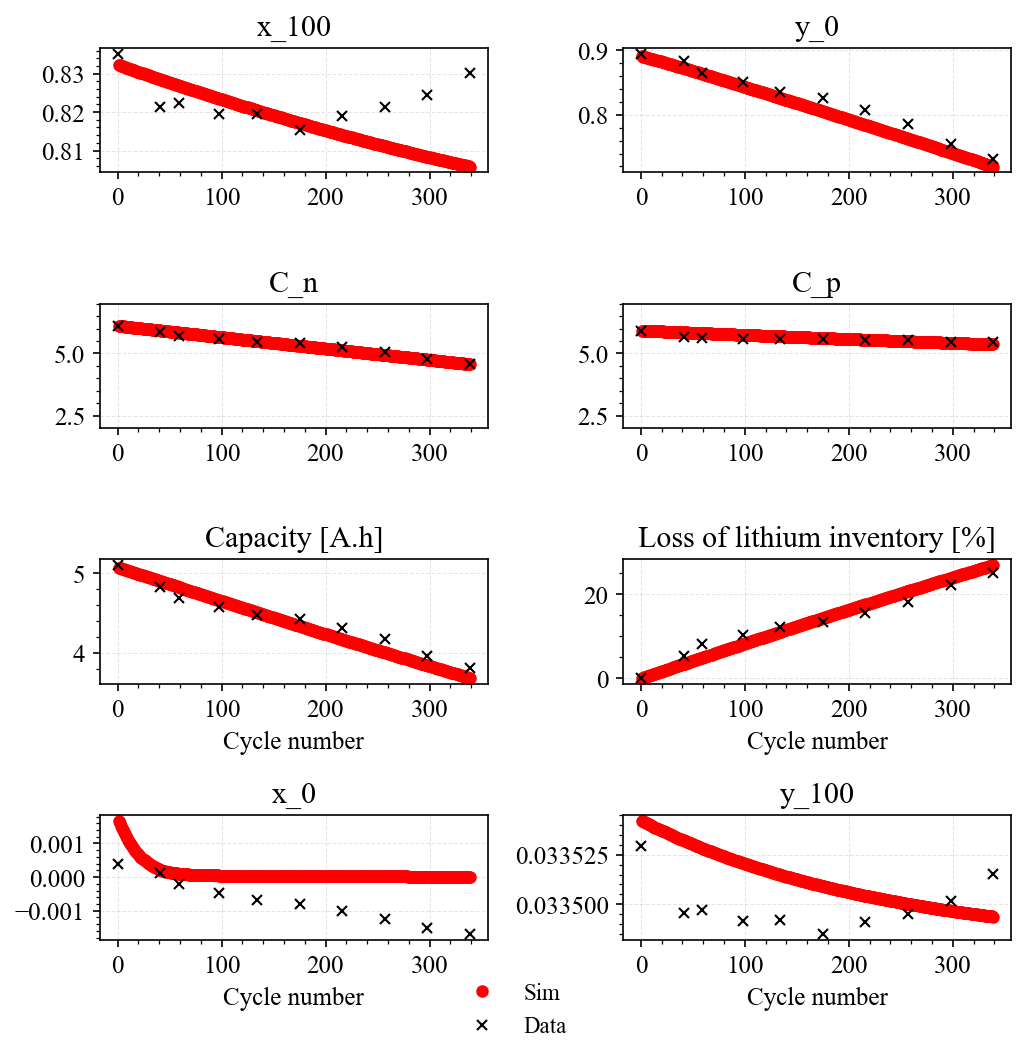

In [18]:
for cell in [1]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    if cell==1:
        experiment = pybamm.Experiment(
            [
                ("Discharge at "+c_rate_d+dis_set,
                "Rest for 5 min",
                "Charge at "+c_rate_c+" until 4.2V", 
                "Hold at 4.2V until C/50")
            ] *dfe.N.iloc[-1],
            termination="50% capacity",
        #     cccv_handling="ode",
        )
    elif cell==19:
        experiment = pybamm.Experiment(
            [
                ("Run Peyman_drive (A)",
                "Rest for 5 min",
                "Charge at 1.5C until 4.2V", 
                "Hold at 4.2V until C/50")
            ] *dfe.N.iloc[-1],
            drive_cycles={"Peyman_drive": Peyman_drive},
            termination="50% capacity",
        #     cccv_handling="ode",
        ) 
    # print(f"Model")
    sol_out = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
    fig = plotc(sol_out,dfe);
#     fig = plotc(sol_out,dfe);

#     plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_'+sim_des+'.png')

In [19]:
for cell in [19]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    if cell==4:
        experiment = pybamm.Experiment(
            [
                ("Discharge at "+c_rate_d+dis_set,
                "Rest for 5 min",
                "Charge at "+c_rate_c+" until 4.2V", 
                "Hold at 4.2V until C/50")
            ] *dfe.N.iloc[-1],
            termination="50% capacity",
        #     cccv_handling="ode",
        )
    elif cell==19:
        experiment = pybamm.Experiment(
            [
                ("Run Peyman_drive (A)",
                "Rest for 5 min",
                "Charge at 1.5C until 4.2V", 
                "Hold at 4.2V until C/50")
            ] *dfe.N.iloc[-1],
            drive_cycles={"Peyman_drive": Peyman_drive},
            termination="50% capacity",
        #     cccv_handling="ode",
        ) 
    # print(f"Model")
    sol_out = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
    fig = plotcn(sol_out,dfe);
#     plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_'+sim_des+'.png')

TypeError: 'NoneType' object is not subscriptable

In [35]:
for cell in [19]:
    cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
    eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
    # print(f"Cell: {cell_no}")
    if cell==4:
        experiment = pybamm.Experiment(
            [
                ("Discharge at "+c_rate_d+dis_set,
                "Rest for 5 min",
                "Charge at "+c_rate_c+" until 4.2V", 
                "Hold at 4.2V until C/50")
            ] *dfe.N.iloc[-1],
            termination="50% capacity",
        #     cccv_handling="ode",
        )
    elif cell==19:
        experiment = pybamm.Experiment(
            [
                ("Run Peyman_drive (A)",
                "Rest for 5 min",
                "Charge at 1.5C until 4.2V", 
                "Hold at 4.2V until C/50")
            ] *dfe.N.iloc[-1],
            drive_cycles={"Peyman_drive": Peyman_drive},
            termination="50% capacity",
        #     cccv_handling="ode",
        ) 
    # print(f"Model")
    sol_out = simulate(x,eps_n_data,eps_p_data,SOC_0,Temp,experiment,timeout=30)
    fig = plotcn(sol_out,dfe);
#     plt.savefig(fig_DIR +'cycling_aging_cell_'+cell_no+'_'+sim_des+'.png')

SystemError: <built-in function DM_get> returned a result with an error set

In [ ]:
all_sumvars_dict["Cycle number"]

In [ ]:
dfe.N.iloc[-1]

In [27]:
df_x["x_0"]

0    0.0
Name: x_0, dtype: object

In [24]:
x

array([18.00176127,  8.19669042,  0.51      ,  1.1396914 ])

In [15]:
# parameter_values = get_parameter_values()

par_val = {}
# Previous i.e. tuning mech sim sep and then Li plating
par_val[0]=[1.2715e-07,1.2727e-06,1.1992,1.353e-9]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,x100,y0
par_val[1]=[1.4819e-07,1.5114e-06,1.2484,1.4732e-09]
# Using only C/5 and 1.5C Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[2]=[1.4493e-07,1.3608e-06,1.199,1.2138e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,x100,y0
par_val[3]=[1.043e-07,1.036e-06,1.208,1.6045e-09]
# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%)
par_val[4]=[8.755e-08,8.572e-07,1.135,1.5788e-09]


# Using C/5, 1.5C and mixed c-rate (Ch:C/5, Dh:1.5C) Cycling aging, cost function with Cn,Cp,C,LLI(%) another initial condition
par_val[5]=[8.7698e-08,8.5848e-07,1.1354,1.5778e-09]
#Using 1.5C(cell 4) and drivexyxle(cell1 9) Cost:C,LLI,Cn,Cp,x100
par_val[6]=[4.0023e-7, 2.22803e-6, 1.3446,9.82e-10]
#Using cells 13 and 19
par_val[7]=[2.2296e-7, 10.7088e-7, 1.02, 7.423e-10]



sno = 7

In [16]:
cell=13

cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)

In [17]:
dis_set

' for 150 min'

In [18]:
experiment = pybamm.Experiment(
    [
    ("Discharge at "+c_rate_d+dis_set,
        "Rest for 5 min",
        "Charge at "+c_rate_c+" until 4.2V", 
        "Hold at 4.2V until C/50")
    ] *dfe.N.iloc[-1],
    termination="50% capacity",
#     cccv_handling="ode",
)

In [19]:
parameter_values.update(
    {
#         "Positive electrode LAM constant proportional term [s-1]":8.755e-8,   #2.5112e-07, #Using Sravan's new fit Dec27 2022
#         "Negative electrode LAM constant proportional term [s-1]":8.572e-7, #2.4741e-06,
#         "Positive electrode LAM constant exponential term":1.135, #1.1942,
#         "Negative electrode LAM constant exponential term":1.135,# 1.1942,
        "Positive electrode LAM constant proportional term [s-1]": par_val[sno][0],
        "Negative electrode LAM constant proportional term [s-1]": par_val[sno][1],
        "Positive electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode LAM constant exponential term": par_val[sno][2],
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16, #4.60788219e-16, #,
        "EC diffusivity [m2.s-1]":8.30909086e-19,# 4.56607447e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,# 1.87422275e+04,
        
        "Lithium plating kinetic rate constant [m.s-1]": par_val[sno][3],
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        
        "Upper voltage cut-off [V]":4.2,
        "SEI resistivity [Ohm.m]":30000.0,
        
        #Cathode disolution
        "Positive electrode dissolution exchange current density": 0,
        "Negative electrode dissolution exchange current density": 0,
        
        "Positive electrode dissolution nickel SEI coefficient": 0,
        "Negative electrode dissolution nickel SEI coefficient": 0.0,
        
        "Positive electrode dissolution nickel intercalation coefficient": 0,
        "Negative electrode dissolution nickel intercalation coefficient": 0.0,
        
    },
    check_already_exists=False,
)

In [15]:
pybamm.set_logging_level("NOTICE")
sim_long = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,                                                      ))
sol_long= sim_long.solve(initial_soc=1, save_at_cycles=1  )

2023-08-15 12:04:49.208 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/451 (15.244 ms elapsed) --------------------
2023-08-15 12:04:49.209 - [NOTICE] callbacks.on_step_start(182): Cycle 1/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:04:49.441 - [NOTICE] callbacks.on_step_start(182): Cycle 1/451, step 2/4: Rest for 5 min
2023-08-15 12:04:49.504 - [NOTICE] callbacks.on_step_start(182): Cycle 1/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:04:49.737 - [NOTICE] callbacks.on_step_start(182): Cycle 1/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:04:50.037 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.071 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:04:50.038 - [NOTICE] callbacks.on_cycle_start(174): Cycle 2/451 (844.615 ms elapsed) --------------------
2023-08-15 12:04:50.038 - [NOTICE] callbacks.on_step_start(182): Cycle 2/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:04:50.211 - [NOTICE] callbacks.on_step_start(182): 

2023-08-15 12:04:55.006 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.044 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:04:55.007 - [NOTICE] callbacks.on_cycle_start(174): Cycle 13/451 (5.814 s elapsed) --------------------
2023-08-15 12:04:55.008 - [NOTICE] callbacks.on_step_start(182): Cycle 13/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:04:55.168 - [NOTICE] callbacks.on_step_start(182): Cycle 13/451, step 2/4: Rest for 5 min
2023-08-15 12:04:55.180 - [NOTICE] callbacks.on_step_start(182): Cycle 13/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:04:55.363 - [NOTICE] callbacks.on_step_start(182): Cycle 13/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:04:55.444 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.042 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:04:55.445 - [NOTICE] callbacks.on_cycle_start(174): Cycle 14/451 (6.252 s elapsed) --------------------
2023-08-15 12:04:55.445 - [NOTICE] callbacks.on

2023-08-15 12:05:00.769 - [NOTICE] callbacks.on_step_start(182): Cycle 24/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:00.856 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.014 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:00.856 - [NOTICE] callbacks.on_cycle_start(174): Cycle 25/451 (11.663 s elapsed) --------------------
2023-08-15 12:05:00.857 - [NOTICE] callbacks.on_step_start(182): Cycle 25/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:01.024 - [NOTICE] callbacks.on_step_start(182): Cycle 25/451, step 2/4: Rest for 5 min
2023-08-15 12:05:01.035 - [NOTICE] callbacks.on_step_start(182): Cycle 25/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:01.222 - [NOTICE] callbacks.on_step_start(182): Cycle 25/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:01.304 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 5.012 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:01.305 - [NOTICE] callbacks.on_cyc

2023-08-15 12:05:06.034 - [NOTICE] callbacks.on_step_start(182): Cycle 36/451, step 2/4: Rest for 5 min
2023-08-15 12:05:06.045 - [NOTICE] callbacks.on_step_start(182): Cycle 36/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:06.235 - [NOTICE] callbacks.on_step_start(182): Cycle 36/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:06.320 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.984 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:06.320 - [NOTICE] callbacks.on_cycle_start(174): Cycle 37/451 (17.127 s elapsed) --------------------
2023-08-15 12:05:06.321 - [NOTICE] callbacks.on_step_start(182): Cycle 37/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:06.489 - [NOTICE] callbacks.on_step_start(182): Cycle 37/451, step 2/4: Rest for 5 min
2023-08-15 12:05:06.501 - [NOTICE] callbacks.on_step_start(182): Cycle 37/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:06.680 - [NOTICE] callbacks.on_step_start(182): Cycle 37/451, s

2023-08-15 12:05:11.352 - [NOTICE] callbacks.on_step_start(182): Cycle 48/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:11.510 - [NOTICE] callbacks.on_step_start(182): Cycle 48/451, step 2/4: Rest for 5 min
2023-08-15 12:05:11.521 - [NOTICE] callbacks.on_step_start(182): Cycle 48/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:11.702 - [NOTICE] callbacks.on_step_start(182): Cycle 48/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:11.780 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.953 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:11.781 - [NOTICE] callbacks.on_cycle_start(174): Cycle 49/451 (22.588 s elapsed) --------------------
2023-08-15 12:05:11.782 - [NOTICE] callbacks.on_step_start(182): Cycle 49/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:11.938 - [NOTICE] callbacks.on_step_start(182): Cycle 49/451, step 2/4: Rest for 5 min
2023-08-15 12:05:11.949 - [NOTICE] callbacks.on_step_start(182): Cycle 49/45

2023-08-15 12:05:16.782 - [NOTICE] callbacks.on_cycle_start(174): Cycle 60/451 (27.589 s elapsed) --------------------
2023-08-15 12:05:16.783 - [NOTICE] callbacks.on_step_start(182): Cycle 60/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:16.942 - [NOTICE] callbacks.on_step_start(182): Cycle 60/451, step 2/4: Rest for 5 min
2023-08-15 12:05:16.953 - [NOTICE] callbacks.on_step_start(182): Cycle 60/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:17.127 - [NOTICE] callbacks.on_step_start(182): Cycle 60/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:17.214 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.922 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:17.214 - [NOTICE] callbacks.on_cycle_start(174): Cycle 61/451 (28.021 s elapsed) --------------------
2023-08-15 12:05:17.215 - [NOTICE] callbacks.on_step_start(182): Cycle 61/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:17.373 - [NOTICE] callbacks.on_step_start(18

2023-08-15 12:05:22.199 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.894 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:22.200 - [NOTICE] callbacks.on_cycle_start(174): Cycle 72/451 (33.007 s elapsed) --------------------
2023-08-15 12:05:22.200 - [NOTICE] callbacks.on_step_start(182): Cycle 72/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:22.367 - [NOTICE] callbacks.on_step_start(182): Cycle 72/451, step 2/4: Rest for 5 min
2023-08-15 12:05:22.378 - [NOTICE] callbacks.on_step_start(182): Cycle 72/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:22.550 - [NOTICE] callbacks.on_step_start(182): Cycle 72/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:22.645 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.891 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:22.645 - [NOTICE] callbacks.on_cycle_start(174): Cycle 73/451 (33.452 s elapsed) --------------------
2023-08-15 12:05:22.646 - [NOTICE] callbacks.

2023-08-15 12:05:27.305 - [NOTICE] callbacks.on_step_start(182): Cycle 83/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:27.731 - [NOTICE] callbacks.on_step_start(182): Cycle 83/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:27.832 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.862 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:27.833 - [NOTICE] callbacks.on_cycle_start(174): Cycle 84/451 (38.640 s elapsed) --------------------
2023-08-15 12:05:27.833 - [NOTICE] callbacks.on_step_start(182): Cycle 84/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:28.027 - [NOTICE] callbacks.on_step_start(182): Cycle 84/451, step 2/4: Rest for 5 min
2023-08-15 12:05:28.039 - [NOTICE] callbacks.on_step_start(182): Cycle 84/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:28.210 - [NOTICE] callbacks.on_step_start(182): Cycle 84/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:28.294 - [NOTICE] callbacks.on_cycle_end(196): Capacit

2023-08-15 12:05:32.701 - [NOTICE] callbacks.on_step_start(182): Cycle 95/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:32.867 - [NOTICE] callbacks.on_step_start(182): Cycle 95/451, step 2/4: Rest for 5 min
2023-08-15 12:05:32.879 - [NOTICE] callbacks.on_step_start(182): Cycle 95/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:33.062 - [NOTICE] callbacks.on_step_start(182): Cycle 95/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:33.149 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.830 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:33.150 - [NOTICE] callbacks.on_cycle_start(174): Cycle 96/451 (43.957 s elapsed) --------------------
2023-08-15 12:05:33.151 - [NOTICE] callbacks.on_step_start(182): Cycle 96/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:33.316 - [NOTICE] callbacks.on_step_start(182): Cycle 96/451, step 2/4: Rest for 5 min
2023-08-15 12:05:33.327 - [NOTICE] callbacks.on_step_start(182): Cycle 96/45

2023-08-15 12:05:38.032 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.800 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:38.032 - [NOTICE] callbacks.on_cycle_start(174): Cycle 107/451 (48.840 s elapsed) --------------------
2023-08-15 12:05:38.033 - [NOTICE] callbacks.on_step_start(182): Cycle 107/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:38.193 - [NOTICE] callbacks.on_step_start(182): Cycle 107/451, step 2/4: Rest for 5 min
2023-08-15 12:05:38.204 - [NOTICE] callbacks.on_step_start(182): Cycle 107/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:38.378 - [NOTICE] callbacks.on_step_start(182): Cycle 107/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:38.474 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.798 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:38.475 - [NOTICE] callbacks.on_cycle_start(174): Cycle 108/451 (49.282 s elapsed) --------------------
2023-08-15 12:05:38.476 - [NOTICE] call

2023-08-15 12:05:43.206 - [NOTICE] callbacks.on_step_start(182): Cycle 118/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:43.390 - [NOTICE] callbacks.on_step_start(182): Cycle 118/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:43.489 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.768 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:43.490 - [NOTICE] callbacks.on_cycle_start(174): Cycle 119/451 (54.297 s elapsed) --------------------
2023-08-15 12:05:43.490 - [NOTICE] callbacks.on_step_start(182): Cycle 119/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:43.649 - [NOTICE] callbacks.on_step_start(182): Cycle 119/451, step 2/4: Rest for 5 min
2023-08-15 12:05:43.661 - [NOTICE] callbacks.on_step_start(182): Cycle 119/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:43.838 - [NOTICE] callbacks.on_step_start(182): Cycle 119/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:44.218 - [NOTICE] callbacks.on_cycle_end(196): 

2023-08-15 12:05:48.901 - [NOTICE] callbacks.on_step_start(182): Cycle 130/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:49.067 - [NOTICE] callbacks.on_step_start(182): Cycle 130/451, step 2/4: Rest for 5 min
2023-08-15 12:05:49.078 - [NOTICE] callbacks.on_step_start(182): Cycle 130/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:49.275 - [NOTICE] callbacks.on_step_start(182): Cycle 130/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:49.368 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.735 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:49.369 - [NOTICE] callbacks.on_cycle_start(174): Cycle 131/451 (1 minute, 0 seconds elapsed) --------------------
2023-08-15 12:05:49.369 - [NOTICE] callbacks.on_step_start(182): Cycle 131/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:49.535 - [NOTICE] callbacks.on_step_start(182): Cycle 131/451, step 2/4: Rest for 5 min
2023-08-15 12:05:49.548 - [NOTICE] callbacks.on_step_start

2023-08-15 12:05:54.225 - [NOTICE] callbacks.on_step_start(182): Cycle 141/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:54.315 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.705 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:54.316 - [NOTICE] callbacks.on_cycle_start(174): Cycle 142/451 (1 minute, 5 seconds elapsed) --------------------
2023-08-15 12:05:54.317 - [NOTICE] callbacks.on_step_start(182): Cycle 142/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:54.483 - [NOTICE] callbacks.on_step_start(182): Cycle 142/451, step 2/4: Rest for 5 min
2023-08-15 12:05:54.492 - [NOTICE] callbacks.on_step_start(182): Cycle 142/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:54.671 - [NOTICE] callbacks.on_step_start(182): Cycle 142/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:05:54.769 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.702 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:05:54.770 - [NOTICE]

2023-08-15 12:05:59.570 - [NOTICE] callbacks.on_step_start(182): Cycle 153/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:05:59.737 - [NOTICE] callbacks.on_step_start(182): Cycle 153/451, step 2/4: Rest for 5 min
2023-08-15 12:05:59.748 - [NOTICE] callbacks.on_step_start(182): Cycle 153/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:05:59.933 - [NOTICE] callbacks.on_step_start(182): Cycle 153/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:00.038 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.672 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:00.038 - [NOTICE] callbacks.on_cycle_start(174): Cycle 154/451 (1 minute, 11 seconds elapsed) --------------------
2023-08-15 12:06:00.039 - [NOTICE] callbacks.on_step_start(182): Cycle 154/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:00.206 - [NOTICE] callbacks.on_step_start(182): Cycle 154/451, step 2/4: Rest for 5 min
2023-08-15 12:06:00.216 - [NOTICE] callbacks.on_step_star

2023-08-15 12:06:05.267 - [NOTICE] callbacks.on_step_start(182): Cycle 164/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:05.357 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.642 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:05.358 - [NOTICE] callbacks.on_cycle_start(174): Cycle 165/451 (1 minute, 16 seconds elapsed) --------------------
2023-08-15 12:06:05.359 - [NOTICE] callbacks.on_step_start(182): Cycle 165/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:05.525 - [NOTICE] callbacks.on_step_start(182): Cycle 165/451, step 2/4: Rest for 5 min
2023-08-15 12:06:05.535 - [NOTICE] callbacks.on_step_start(182): Cycle 165/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:05.717 - [NOTICE] callbacks.on_step_start(182): Cycle 165/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:05.812 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.639 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:05.813 - [NOTICE

2023-08-15 12:06:10.432 - [NOTICE] callbacks.on_step_start(182): Cycle 176/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:10.600 - [NOTICE] callbacks.on_step_start(182): Cycle 176/451, step 2/4: Rest for 5 min
2023-08-15 12:06:10.611 - [NOTICE] callbacks.on_step_start(182): Cycle 176/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:10.795 - [NOTICE] callbacks.on_step_start(182): Cycle 176/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:10.896 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.609 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:10.897 - [NOTICE] callbacks.on_cycle_start(174): Cycle 177/451 (1 minute, 22 seconds elapsed) --------------------
2023-08-15 12:06:10.897 - [NOTICE] callbacks.on_step_start(182): Cycle 177/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:11.070 - [NOTICE] callbacks.on_step_start(182): Cycle 177/451, step 2/4: Rest for 5 min
2023-08-15 12:06:11.081 - [NOTICE] callbacks.on_step_star

2023-08-15 12:06:15.858 - [NOTICE] callbacks.on_step_start(182): Cycle 187/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:15.952 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.578 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:15.953 - [NOTICE] callbacks.on_cycle_start(174): Cycle 188/451 (1 minute, 27 seconds elapsed) --------------------
2023-08-15 12:06:15.954 - [NOTICE] callbacks.on_step_start(182): Cycle 188/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:16.127 - [NOTICE] callbacks.on_step_start(182): Cycle 188/451, step 2/4: Rest for 5 min
2023-08-15 12:06:16.138 - [NOTICE] callbacks.on_step_start(182): Cycle 188/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:16.314 - [NOTICE] callbacks.on_step_start(182): Cycle 188/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:16.407 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.575 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:16.408 - [NOTICE

2023-08-15 12:06:21.135 - [NOTICE] callbacks.on_step_start(182): Cycle 199/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:21.302 - [NOTICE] callbacks.on_step_start(182): Cycle 199/451, step 2/4: Rest for 5 min
2023-08-15 12:06:21.317 - [NOTICE] callbacks.on_step_start(182): Cycle 199/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:21.514 - [NOTICE] callbacks.on_step_start(182): Cycle 199/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:21.631 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.544 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:21.632 - [NOTICE] callbacks.on_cycle_start(174): Cycle 200/451 (1 minute, 32 seconds elapsed) --------------------
2023-08-15 12:06:21.633 - [NOTICE] callbacks.on_step_start(182): Cycle 200/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:21.845 - [NOTICE] callbacks.on_step_start(182): Cycle 200/451, step 2/4: Rest for 5 min
2023-08-15 12:06:21.856 - [NOTICE] callbacks.on_step_star

2023-08-15 12:06:26.566 - [NOTICE] callbacks.on_step_start(182): Cycle 210/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:26.659 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.513 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:26.659 - [NOTICE] callbacks.on_cycle_start(174): Cycle 211/451 (1 minute, 37 seconds elapsed) --------------------
2023-08-15 12:06:26.660 - [NOTICE] callbacks.on_step_start(182): Cycle 211/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:26.830 - [NOTICE] callbacks.on_step_start(182): Cycle 211/451, step 2/4: Rest for 5 min
2023-08-15 12:06:26.842 - [NOTICE] callbacks.on_step_start(182): Cycle 211/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:27.024 - [NOTICE] callbacks.on_step_start(182): Cycle 211/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:27.124 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.510 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:27.125 - [NOTICE

2023-08-15 12:06:32.187 - [NOTICE] callbacks.on_step_start(182): Cycle 222/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:32.346 - [NOTICE] callbacks.on_step_start(182): Cycle 222/451, step 2/4: Rest for 5 min
2023-08-15 12:06:32.356 - [NOTICE] callbacks.on_step_start(182): Cycle 222/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:32.536 - [NOTICE] callbacks.on_step_start(182): Cycle 222/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:32.645 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.479 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:32.646 - [NOTICE] callbacks.on_cycle_start(174): Cycle 223/451 (1 minute, 43 seconds elapsed) --------------------
2023-08-15 12:06:32.647 - [NOTICE] callbacks.on_step_start(182): Cycle 223/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:32.805 - [NOTICE] callbacks.on_step_start(182): Cycle 223/451, step 2/4: Rest for 5 min
2023-08-15 12:06:32.816 - [NOTICE] callbacks.on_step_star

2023-08-15 12:06:37.589 - [NOTICE] callbacks.on_step_start(182): Cycle 233/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:37.683 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.448 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:37.684 - [NOTICE] callbacks.on_cycle_start(174): Cycle 234/451 (1 minute, 48 seconds elapsed) --------------------
2023-08-15 12:06:37.684 - [NOTICE] callbacks.on_step_start(182): Cycle 234/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:37.853 - [NOTICE] callbacks.on_step_start(182): Cycle 234/451, step 2/4: Rest for 5 min
2023-08-15 12:06:37.864 - [NOTICE] callbacks.on_step_start(182): Cycle 234/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:38.052 - [NOTICE] callbacks.on_step_start(182): Cycle 234/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:38.151 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.445 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:38.152 - [NOTICE

2023-08-15 12:06:42.755 - [NOTICE] callbacks.on_step_start(182): Cycle 245/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:42.916 - [NOTICE] callbacks.on_step_start(182): Cycle 245/451, step 2/4: Rest for 5 min
2023-08-15 12:06:42.927 - [NOTICE] callbacks.on_step_start(182): Cycle 245/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:43.109 - [NOTICE] callbacks.on_step_start(182): Cycle 245/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:43.223 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.414 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:43.223 - [NOTICE] callbacks.on_cycle_start(174): Cycle 246/451 (1 minute, 54 seconds elapsed) --------------------
2023-08-15 12:06:43.224 - [NOTICE] callbacks.on_step_start(182): Cycle 246/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:43.383 - [NOTICE] callbacks.on_step_start(182): Cycle 246/451, step 2/4: Rest for 5 min
2023-08-15 12:06:43.394 - [NOTICE] callbacks.on_step_star

2023-08-15 12:06:48.170 - [NOTICE] callbacks.on_step_start(182): Cycle 256/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:48.276 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.382 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:48.277 - [NOTICE] callbacks.on_cycle_start(174): Cycle 257/451 (1 minute, 59 seconds elapsed) --------------------
2023-08-15 12:06:48.277 - [NOTICE] callbacks.on_step_start(182): Cycle 257/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:48.449 - [NOTICE] callbacks.on_step_start(182): Cycle 257/451, step 2/4: Rest for 5 min
2023-08-15 12:06:48.459 - [NOTICE] callbacks.on_step_start(182): Cycle 257/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:48.647 - [NOTICE] callbacks.on_step_start(182): Cycle 257/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:48.750 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.379 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:48.750 - [NOTICE

2023-08-15 12:06:53.420 - [NOTICE] callbacks.on_step_start(182): Cycle 268/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:53.600 - [NOTICE] callbacks.on_step_start(182): Cycle 268/451, step 2/4: Rest for 5 min
2023-08-15 12:06:53.611 - [NOTICE] callbacks.on_step_start(182): Cycle 268/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:53.770 - [NOTICE] callbacks.on_step_start(182): Cycle 268/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:53.886 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.347 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:53.887 - [NOTICE] callbacks.on_cycle_start(174): Cycle 269/451 (2 minutes, 5 seconds elapsed) --------------------
2023-08-15 12:06:53.887 - [NOTICE] callbacks.on_step_start(182): Cycle 269/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:54.048 - [NOTICE] callbacks.on_step_start(182): Cycle 269/451, step 2/4: Rest for 5 min
2023-08-15 12:06:54.058 - [NOTICE] callbacks.on_step_star

2023-08-15 12:06:58.955 - [NOTICE] callbacks.on_step_start(182): Cycle 279/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:59.070 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.316 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:59.071 - [NOTICE] callbacks.on_cycle_start(174): Cycle 280/451 (2 minutes, 10 seconds elapsed) --------------------
2023-08-15 12:06:59.071 - [NOTICE] callbacks.on_step_start(182): Cycle 280/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:06:59.253 - [NOTICE] callbacks.on_step_start(182): Cycle 280/451, step 2/4: Rest for 5 min
2023-08-15 12:06:59.264 - [NOTICE] callbacks.on_step_start(182): Cycle 280/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:06:59.427 - [NOTICE] callbacks.on_step_start(182): Cycle 280/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:06:59.541 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.313 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:06:59.542 - [NOTIC

2023-08-15 12:07:04.871 - [NOTICE] callbacks.on_step_start(182): Cycle 291/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:05.056 - [NOTICE] callbacks.on_step_start(182): Cycle 291/451, step 2/4: Rest for 5 min
2023-08-15 12:07:05.067 - [NOTICE] callbacks.on_step_start(182): Cycle 291/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:05.235 - [NOTICE] callbacks.on_step_start(182): Cycle 291/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:05.350 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.280 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:05.350 - [NOTICE] callbacks.on_cycle_start(174): Cycle 292/451 (2 minutes, 16 seconds elapsed) --------------------
2023-08-15 12:07:05.351 - [NOTICE] callbacks.on_step_start(182): Cycle 292/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:05.510 - [NOTICE] callbacks.on_step_start(182): Cycle 292/451, step 2/4: Rest for 5 min
2023-08-15 12:07:05.521 - [NOTICE] callbacks.on_step_sta

2023-08-15 12:07:10.494 - [NOTICE] callbacks.on_step_start(182): Cycle 302/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:10.599 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.248 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:10.599 - [NOTICE] callbacks.on_cycle_start(174): Cycle 303/451 (2 minutes, 21 seconds elapsed) --------------------
2023-08-15 12:07:10.600 - [NOTICE] callbacks.on_step_start(182): Cycle 303/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:10.797 - [NOTICE] callbacks.on_step_start(182): Cycle 303/451, step 2/4: Rest for 5 min
2023-08-15 12:07:10.808 - [NOTICE] callbacks.on_step_start(182): Cycle 303/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:10.971 - [NOTICE] callbacks.on_step_start(182): Cycle 303/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:11.076 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.245 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:11.076 - [NOTIC

2023-08-15 12:07:15.832 - [NOTICE] callbacks.on_step_start(182): Cycle 314/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:16.035 - [NOTICE] callbacks.on_step_start(182): Cycle 314/451, step 2/4: Rest for 5 min
2023-08-15 12:07:16.046 - [NOTICE] callbacks.on_step_start(182): Cycle 314/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:16.208 - [NOTICE] callbacks.on_step_start(182): Cycle 314/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:16.312 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.213 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:16.313 - [NOTICE] callbacks.on_cycle_start(174): Cycle 315/451 (2 minutes, 27 seconds elapsed) --------------------
2023-08-15 12:07:16.313 - [NOTICE] callbacks.on_step_start(182): Cycle 315/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:16.512 - [NOTICE] callbacks.on_step_start(182): Cycle 315/451, step 2/4: Rest for 5 min
2023-08-15 12:07:16.523 - [NOTICE] callbacks.on_step_sta

2023-08-15 12:07:21.514 - [NOTICE] callbacks.on_step_start(182): Cycle 325/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:21.623 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.180 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:21.624 - [NOTICE] callbacks.on_cycle_start(174): Cycle 326/451 (2 minutes, 32 seconds elapsed) --------------------
2023-08-15 12:07:21.624 - [NOTICE] callbacks.on_step_start(182): Cycle 326/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:21.835 - [NOTICE] callbacks.on_step_start(182): Cycle 326/451, step 2/4: Rest for 5 min
2023-08-15 12:07:21.846 - [NOTICE] callbacks.on_step_start(182): Cycle 326/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:22.007 - [NOTICE] callbacks.on_step_start(182): Cycle 326/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:22.115 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.177 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:22.115 - [NOTIC

2023-08-15 12:07:26.975 - [NOTICE] callbacks.on_step_start(182): Cycle 337/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:27.153 - [NOTICE] callbacks.on_step_start(182): Cycle 337/451, step 2/4: Rest for 5 min
2023-08-15 12:07:27.164 - [NOTICE] callbacks.on_step_start(182): Cycle 337/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:27.329 - [NOTICE] callbacks.on_step_start(182): Cycle 337/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:27.439 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.144 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:27.440 - [NOTICE] callbacks.on_cycle_start(174): Cycle 338/451 (2 minutes, 38 seconds elapsed) --------------------
2023-08-15 12:07:27.440 - [NOTICE] callbacks.on_step_start(182): Cycle 338/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:27.650 - [NOTICE] callbacks.on_step_start(182): Cycle 338/451, step 2/4: Rest for 5 min
2023-08-15 12:07:27.660 - [NOTICE] callbacks.on_step_sta

2023-08-15 12:07:32.728 - [NOTICE] callbacks.on_step_start(182): Cycle 348/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:32.861 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.111 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:32.862 - [NOTICE] callbacks.on_cycle_start(174): Cycle 349/451 (2 minutes, 44 seconds elapsed) --------------------
2023-08-15 12:07:32.862 - [NOTICE] callbacks.on_step_start(182): Cycle 349/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:33.042 - [NOTICE] callbacks.on_step_start(182): Cycle 349/451, step 2/4: Rest for 5 min
2023-08-15 12:07:33.053 - [NOTICE] callbacks.on_step_start(182): Cycle 349/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:33.214 - [NOTICE] callbacks.on_step_start(182): Cycle 349/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:33.323 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.108 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:33.324 - [NOTIC

2023-08-15 12:07:38.220 - [NOTICE] callbacks.on_step_start(182): Cycle 360/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:38.381 - [NOTICE] callbacks.on_step_start(182): Cycle 360/451, step 2/4: Rest for 5 min
2023-08-15 12:07:38.393 - [NOTICE] callbacks.on_step_start(182): Cycle 360/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:38.547 - [NOTICE] callbacks.on_step_start(182): Cycle 360/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:38.679 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.075 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:38.680 - [NOTICE] callbacks.on_cycle_start(174): Cycle 361/451 (2 minutes, 49 seconds elapsed) --------------------
2023-08-15 12:07:38.680 - [NOTICE] callbacks.on_step_start(182): Cycle 361/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:38.839 - [NOTICE] callbacks.on_step_start(182): Cycle 361/451, step 2/4: Rest for 5 min
2023-08-15 12:07:38.850 - [NOTICE] callbacks.on_step_sta

2023-08-15 12:07:44.723 - [NOTICE] callbacks.on_step_start(182): Cycle 371/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:44.878 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.041 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:44.879 - [NOTICE] callbacks.on_cycle_start(174): Cycle 372/451 (2 minutes, 56 seconds elapsed) --------------------
2023-08-15 12:07:44.880 - [NOTICE] callbacks.on_step_start(182): Cycle 372/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:45.047 - [NOTICE] callbacks.on_step_start(182): Cycle 372/451, step 2/4: Rest for 5 min
2023-08-15 12:07:45.059 - [NOTICE] callbacks.on_step_start(182): Cycle 372/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:45.217 - [NOTICE] callbacks.on_step_start(182): Cycle 372/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:45.346 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.038 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:45.347 - [NOTIC

2023-08-15 12:07:50.321 - [NOTICE] callbacks.on_step_start(182): Cycle 383/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:50.529 - [NOTICE] callbacks.on_step_start(182): Cycle 383/451, step 2/4: Rest for 5 min
2023-08-15 12:07:50.542 - [NOTICE] callbacks.on_step_start(182): Cycle 383/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:50.724 - [NOTICE] callbacks.on_step_start(182): Cycle 383/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:50.867 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.004 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:50.868 - [NOTICE] callbacks.on_cycle_start(174): Cycle 384/451 (3 minutes, 2 seconds elapsed) --------------------
2023-08-15 12:07:50.868 - [NOTICE] callbacks.on_step_start(182): Cycle 384/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:51.051 - [NOTICE] callbacks.on_step_start(182): Cycle 384/451, step 2/4: Rest for 5 min
2023-08-15 12:07:51.062 - [NOTICE] callbacks.on_step_star

2023-08-15 12:07:56.276 - [NOTICE] callbacks.on_step_start(182): Cycle 394/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:56.393 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.970 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:56.394 - [NOTICE] callbacks.on_cycle_start(174): Cycle 395/451 (3 minutes, 7 seconds elapsed) --------------------
2023-08-15 12:07:56.394 - [NOTICE] callbacks.on_step_start(182): Cycle 395/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:07:56.576 - [NOTICE] callbacks.on_step_start(182): Cycle 395/451, step 2/4: Rest for 5 min
2023-08-15 12:07:56.587 - [NOTICE] callbacks.on_step_start(182): Cycle 395/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:07:56.747 - [NOTICE] callbacks.on_step_start(182): Cycle 395/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:07:56.889 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.967 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:07:56.890 - [NOTICE

2023-08-15 12:08:01.923 - [NOTICE] callbacks.on_step_start(182): Cycle 406/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:08:02.086 - [NOTICE] callbacks.on_step_start(182): Cycle 406/451, step 2/4: Rest for 5 min
2023-08-15 12:08:02.096 - [NOTICE] callbacks.on_step_start(182): Cycle 406/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:08:02.289 - [NOTICE] callbacks.on_step_start(182): Cycle 406/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:08:02.428 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.933 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:08:02.428 - [NOTICE] callbacks.on_cycle_start(174): Cycle 407/451 (3 minutes, 13 seconds elapsed) --------------------
2023-08-15 12:08:02.429 - [NOTICE] callbacks.on_step_start(182): Cycle 407/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:08:02.592 - [NOTICE] callbacks.on_step_start(182): Cycle 407/451, step 2/4: Rest for 5 min
2023-08-15 12:08:02.602 - [NOTICE] callbacks.on_step_sta

2023-08-15 12:08:07.759 - [NOTICE] callbacks.on_step_start(182): Cycle 417/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:08:07.878 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.899 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:08:07.879 - [NOTICE] callbacks.on_cycle_start(174): Cycle 418/451 (3 minutes, 19 seconds elapsed) --------------------
2023-08-15 12:08:07.879 - [NOTICE] callbacks.on_step_start(182): Cycle 418/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:08:08.063 - [NOTICE] callbacks.on_step_start(182): Cycle 418/451, step 2/4: Rest for 5 min
2023-08-15 12:08:08.076 - [NOTICE] callbacks.on_step_start(182): Cycle 418/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:08:08.270 - [NOTICE] callbacks.on_step_start(182): Cycle 418/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:08:08.389 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.896 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:08:08.390 - [NOTIC

2023-08-15 12:08:13.376 - [NOTICE] callbacks.on_step_start(182): Cycle 429/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:08:13.556 - [NOTICE] callbacks.on_step_start(182): Cycle 429/451, step 2/4: Rest for 5 min
2023-08-15 12:08:13.568 - [NOTICE] callbacks.on_step_start(182): Cycle 429/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:08:13.765 - [NOTICE] callbacks.on_step_start(182): Cycle 429/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:08:13.883 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.861 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:08:13.883 - [NOTICE] callbacks.on_cycle_start(174): Cycle 430/451 (3 minutes, 25 seconds elapsed) --------------------
2023-08-15 12:08:13.884 - [NOTICE] callbacks.on_step_start(182): Cycle 430/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:08:14.074 - [NOTICE] callbacks.on_step_start(182): Cycle 430/451, step 2/4: Rest for 5 min
2023-08-15 12:08:14.085 - [NOTICE] callbacks.on_step_sta

2023-08-15 12:08:19.278 - [NOTICE] callbacks.on_step_start(182): Cycle 440/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:08:19.415 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.826 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:08:19.416 - [NOTICE] callbacks.on_cycle_start(174): Cycle 441/451 (3 minutes, 30 seconds elapsed) --------------------
2023-08-15 12:08:19.417 - [NOTICE] callbacks.on_step_start(182): Cycle 441/451, step 1/4: Discharge at C/5 for 150 min
2023-08-15 12:08:19.583 - [NOTICE] callbacks.on_step_start(182): Cycle 441/451, step 2/4: Rest for 5 min
2023-08-15 12:08:19.593 - [NOTICE] callbacks.on_step_start(182): Cycle 441/451, step 3/4: Charge at C/5 until 4.2V
2023-08-15 12:08:19.786 - [NOTICE] callbacks.on_step_start(182): Cycle 441/451, step 4/4: Hold at 4.2V until C/50
2023-08-15 12:08:19.924 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.823 Ah (originally 5.071 Ah, will stop at 2.535 Ah)
2023-08-15 12:08:19.925 - [NOTIC

In [16]:
x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]


LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
LLI_mol= sol_long.summary_variables["Total lithium lost [mol]"]
LLI_Side_mol= sol_long.summary_variables["Total lithium lost to side reactions [mol]"]
LLI_plating_mol= sol_long.summary_variables["Loss of lithium to lithium plating [mol]"]
LLI_SEI_mol= sol_long.summary_variables["Loss of lithium to SEI [mol]"]


cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

In [22]:
from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
        "LLI_mol":LLI_mol,
        "LLI_Side_mol":LLI_Side_mol
    
       }
savemat("Peyman__cell_July25.mat",mdic)